# Predict rating of review using BoardGameGeek Reviews dataset

**The goal of this project is to use the corpus of reviews present in this dataset, learn the reviews and their corresponding rating.**

**Once the model is trained using the review data, we ask the user to input a new review and predict the rating of that review.**

We begin by importing all the basic libraries:

In [0]:
!pip install -q pandas numpy nltk scikit-learn matplotlib seaborn wordcloud ipython

In [2]:
import os
import pickle
import string
import re
import gc
import random

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display, HTML

nltk.download(['words', 'stopwords', 'wordnet'], quiet=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


True

Here we define the paths of the dataset and the pickle files

We will be pickling our dataset after every major step due to save time

Due to the sheer amount of data we have, it does take time to do pre-processing

Also, I will be invoking the garbage collector often just to save memory as we need every bit of it due to the volume of input data

In [0]:
DATA_DIR = "/content/drive/My Drive/Colab Notebooks/data/"

DATASET = DATA_DIR + "bgg-13m-reviews.csv"

REVIEWS_PICKLE = DATA_DIR + "reviews.pkl"
REVIEWS_DATA_CHANGED = False

CLEAN_TEXT_PICKLE = DATA_DIR + "clean_text.pkl"
LEMMATIZED_PICKLE = DATA_DIR + "lemmatized.pkl"
STOPWORDS_PICKLE = DATA_DIR + "stopwords.pkl"
CLEANED_PICKLE = DATA_DIR + "cleaned_reviews.pkl"

Now that we've got the formalities out of our way, let's start exploring our dataset and see how we can solve this problem.

First, we need to load the dataset like so:

In [4]:
reviews = pd.DataFrame()

if os.path.isfile(REVIEWS_PICKLE) or REVIEWS_DATA_CHANGED:
  print('Pickled reviews found. Loading from pickle file.')
  reviews = pd.read_pickle(REVIEWS_PICKLE, compression="gzip")
else:
  print("Reading reviews csv")
  reviews = pd.read_csv(REVIEWS_FILE, usecols=['comment', 'rating'])
  print("Pickling dataset")
  reviews.to_pickle(REVIEWS_PICKLE, compression="gzip")

reviews = reviews.reindex(columns=['comment','rating'])

reviews = reviews.sample(frac=1, random_state=3).reset_index(drop=True)

gc.collect()
display(reviews)

Pickled reviews found. Loading from pickle file.


,comment,rating
0,NaN,6.5
1,NaN,8.0
2,NaN,8.0
3,NaN,7.0
4,http://boardgamers.ro/saboteur-recenzie/,6.0
...,...,...
13170068,"""Solid deck-builder in which you need to strat...",6.5
13170069,I adore this game. Not only is it an incredibl...,10.0
13170070,NaN,9.0
13170071,NaN,6.0


Great! We've got our dataset loaded.

Also, consecutive runs should be faster because we've pickled the data

As we can see, we've got several rows with no review and just a rating

We will be removing this rows as we cannot use them

In [5]:
empty_reviews = reviews.comment.isna().sum()
print("Dropping {} rows from dataset".format(empty_reviews))

reviews.dropna(subset=['comment'], inplace=True)
reviews = reviews.reset_index(drop=True)

print("We now have {} reviews remaining".format(reviews.shape[0]))

gc.collect()
display(reviews)

Dropping 10531901 rows from dataset
We now have 2638172 reviews remaining


,comment,rating
0,http://boardgamers.ro/saboteur-recenzie/,6.0
1,A nice family game but a little light for my o...,5.0
2,"""This was the first modern board game that my ...",8.0
3,"Great two player game. In fact, how did Knizia...",9.0
4,Risk but with more pieces.,5.0
...,...,...
2638167,Great light game. Theme and simplicity make it...,7.0
2638168,Detailed board All sleeved,9.0
2638169,"""Solid deck-builder in which you need to strat...",6.5
2638170,I adore this game. Not only is it an incredibl...,10.0


## Cleaning the reviews

Wow! That was a huge difference. We've shed off about 10 million rows!

Now, we need to begin cleaning up these reviews as they have a lot of redundant information and context.

For this dataset, we will be removing the following patterns from the text:
- Words less than 3 and more than 15 characters
- Special characters
- URLs
- HTML tags
- All kinds of redundant whitespaces
- Words that have numbers between them
- Words that begin or end with a number

Once all this is done, we tokenize the reviews and save them in the dataframe

In [6]:
def clean_text(text):
    text = text.lower().strip()
    text = " ".join([w for w in text.split() if len(w) >= 3 and len(w) <= 15])
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w+\d+\w*', '', text)
    text = re.sub('\d+\w+\d*', '', text)
    text = re.sub('\W+', '', text)
    text = tokenizer.tokenize(text)
    return text

if os.path.isfile(CLEAN_TEXT_PICKLE) or REVIEWS_DATA_CHANGED:
  print("Pickled clean text found. Loading from pickle file.")
  reviews = pd.read_pickle(CLEAN_TEXT_PICKLE, compression="gzip")
else:
  print("Cleaning reviews")
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  reviews['comment'] = reviews['comment'].apply(clean_text)
  print("Pickling cleaned dataset")
  reviews.to_pickle(CLEAN_TEXT_PICKLE, compression="gzip")

gc.collect()
display(reviews)

Pickled clean text found. Loading from pickle file.


,comment,rating
0,"[currently, this, sits, list, favorite, game]",10.0
1,"[know, says, how, many, plays, but, many, many...",10.0
2,"[will, never, tire, this, game, awesome]",10.0
3,"[this, probably, the, best, game, ever, played...",10.0
4,"[fantastic, game, got, hooked, games, all, ove...",10.0
...,...,...
2638167,"[horrible, party, game, dumping, this, one]",3.0
2638168,"[difficult, build, anything, all, with, the, i...",3.0
2638169,"[lego, created, version, pictionary, only, you...",3.0
2638170,"[this, game, very, similar, creationary, comes...",2.5


We've gotten rid of most of the oddities in our text data.

But, when it comes to such huge models text is present in many forms of speech so it's better to lemmatize them. But, before we do that, let's see how many unique words we currently have.

In [7]:
uniq_words = []

unique_words = reviews.explode('comment').comment.nunique()
uniq_words.append(unique_words)

print("Unique words before lemmatizing {}".format(unique_words))

Unique words before lemmatizing 313013


Wow, that's a lot of words. Let's see what happens after lemmatizing our reviews.

In [8]:
def lemmatize_data(text):
    return [lemmatizer.lemmatize(w) for w in text]

if os.path.isfile(LEMMATIZED_PICKLE) or REVIEWS_DATA_CHANGED:
  print("Pickled lemmatized reviews found. Loading from pickle file.")
  reviews = pd.read_pickle(LEMMATIZED_PICKLE, compression="gzip")
else:
  print("Lemmatizing reviews")
  lemmatizer = nltk.stem.WordNetLemmatizer()
  reviews['comment'] = reviews['comment'].apply(lemmatize_data)
  print("Pickling lemmatized reviews")
  reviews.to_pickle(LEMMATIZED_PICKLE, compression="gzip")

display(reviews)
gc.collect()

unique_words = reviews.explode('comment').comment.nunique()
uniq_words.append(unique_words)
print("Unique words after lemmatizing {}".format(unique_words))

Pickled lemmatized reviews found. Loading from pickle file.


,comment,rating
0,"[currently, this, sits, list, favorite, game]",10.0
1,"[know, say, how, many, play, but, many, many, ...",10.0
2,"[will, never, tire, this, game, awesome]",10.0
3,"[this, probably, the, best, game, ever, played...",10.0
4,"[fantastic, game, got, hooked, game, all, over...",10.0
...,...,...
2638167,"[horrible, party, game, dumping, this, one]",3.0
2638168,"[difficult, build, anything, all, with, the, i...",3.0
2638169,"[lego, created, version, pictionary, only, you...",3.0
2638170,"[this, game, very, similar, creationary, come,...",2.5


Unique words after lemmatizing 300678


That's a drastic reduction. This should help reduce the strain on our model. 

Next, we will be removing our stopwords. But, before we do that, let us have a look at a WordCloud and get a vague idea of what kinds of words we have.

To help visualize things better, I will be splitting the reviews into two sets. 

Any reviews that have a rating less than or equal to 5 we will keep them in the "negative" reviews wordcloud and the remaining in a "positive" reviews wordcloud.

Now let's remove the stopwords as well as they are mostly redundant for our training and mainly help us understand context.

We do have quite a fair number of custom words to remove and I've identified some custom words that I've added to the list as well.

In [9]:
def remove_stopwords(text):
    words = [
        w for w in text if w not in stop_words and w in words_corpus or not w.isalpha()]
    words = list(filter(lambda word: len(word)>2, set(words)))
    return words

if os.path.isfile(STOPWORDS_PICKLE) or REVIEWS_DATA_CHANGED:
  print("Reading stopwords pickle")
  reviews = pd.read_pickle(STOPWORDS_PICKLE, compression="gzip")
else:
  words_corpus = set(nltk.corpus.words.words())

  stop_words_json = {"en":["a", "a's", "able", "about", "above", "according", "accordingly", "across", "actually", "after", "afterwards", "again", "against", "ain't", "aint", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "another", "any", "anybody", "anyhow", "anyone", "anything", "anyway", "anyways", "anywhere", "apart", "appear", "appreciate", "appropriate", "are", "aren't", "arent", "around", "as", "aside", "ask", "asking", "associated", "at", "available", "away", "awfully", "b", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "both", "brief", "but", "by", "c", "c'mon", "cmon", "cs", "c's", "came", "can", "can't", "cannot", "cant", "cause", "causes", "certain", "certainly", "changes", "clearly", "co", "com", "come", "comes", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn't", "course", "currently", "d", "definitely", "described", "despite", "did", "didn't", "different", "do", "does", "doesn't", "doesn", "doing", "don't", "done", "down", "downwards", "during", "e", "each", "edu", "eg", "eight", "either", "else", "elsewhere", "enough", "entirely", "especially", "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "f", "far", "few", "fifth", "first", "five", "followed", "following", "follows", "for", "former", "formerly", "forth", "four", "from", "further", "furthermore", "g", "get", "gets", "getting", "given", "gives", "go", "goes", "going", "gone", "got", "gotten", "greetings", "h", "had", "hadn't", "hadnt", "happens", "hardly", "has", "hasn't", "hasnt", "have", "haven't", "havent", "having", "he", "he's", "hes", "hello", "help", "hence", "her", "here", "here's", "heres", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "hi", "him", "himself", "his", "hither", "hopefully", "how", "howbeit", "however", "i", "i'd", "id", "i'll", "i'm", "im", "i've", "ive", "ie", "if", "ignored", "immediate", "in", "inasmuch", "inc", "indeed", "indicate", "indicated", "indicates", "inner", "insofar", "instead", "into", "inward", "is", "isn't", "isnt", "it", "it'd", "itd", "it'll", "itll", "it's", "its", "itself", "j", "just", "k", "keep", "keeps", "kept", "know", "known", "knows", "l", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "let's", "lets", "like", "liked", "likely", "little", "look", "looking", "looks", "ltd", "m", "mainly", "many", "may", "maybe", "me", "mean", "meanwhile", "merely", "might", "more", "moreover", "most", "mostly", "much", "must", "my", "myself", "n", "name", "namely", "nd", "near", "nearly", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "no", "nobody", "non", "none", "noone", "nor", "normally", "not", "nothing", "novel", "now", "nowhere", "o", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "on", "once", "one", "ones", "only", "onto", "or", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "own", "p", "particular", "particularly", "per", "perhaps", "placed", "please", "plus", "possible", "presumably", "probably", "provides", "q", "que", "quite", "qv", "r", "rather", "rd", "re", "really", "reasonably", "regarding", "regardless", "regards", "relatively", "respectively", "right", "s", "said", "same", "saw", "say", "saying", "says", "second", "secondly", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "shall", "she", "should", "shouldn't", "shouldnt", "since", "six", "so", "some", "somebody", "somehow", "someone", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specified", "specify", "specifying", "still", "sub", "such", "sup", "sure", "t", "t's", "ts", "take", "taken", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that's", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "there's", "theres", "thereafter", "thereby", "therefore", "therein", "theres", "thereupon", "these", "they", "they'd", "theyd", "they'll", "theyll", "they're", "theyre", "theyve", "they've", "think", "third", "this", "thorough", "thoroughly", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "twice", "two", "u", "un", "under", "unfortunately", "unless", "unlikely", "until", "unto", "up", "upon", "us", "use", "used", "useful", "uses", "using", "usually", "uucp", "v", "value", "various", "very", "via", "viz", "vs", "w", "wa", "want", "wants", "was", "wasn't", "wasnt", "way", "we", "we'd", "we'll", "we're", "we've", "weve", "welcome", "well", "went", "were", "weren't", "werent", "what", "what's", "whats", "whatever", "when", "whence", "whenever", "where", "wheres", "where's", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "who's", "whos", "whoever", "whole", "whom", "whose", "why", "will", "willing", "wish", "with", "within", "without", "won't", "wont", "wonder", "would", "wouldn't", "wouldny", "x", "y", "yes", "yet", "you", "you'd", "youd", "you'll", "youll", "you're", "youre", "you've", "youve", "your", "yours", "yours", "yourself", "yourselves", "z", "zero"]}
  stop_words_json_en = set(stop_words_json['en'])

  stop_words_nltk_en = set(stopwords.words('english'))

  custom_stop_words = ["rating", "ish", "havn", "dice", "end", "set", "doesnt", "give", "find", "doe", "system", "tile", "table", "deck", "box", "made", "part", "based", "worker", "wife", "put", "havent", "game", "play", "player", "one", "two", "card", "ha", "wa", "dont", "board", "time", "make", "rule", "thing", "version", "mechanic", "year", "theme", "rating", "family", "child", "money", "edition", "collection", "piece", "wasnt", "didnt"]

  stop_words = stop_words_nltk_en.union(stop_words_json_en, custom_stop_words)

  print("Removing {} stopwords from text".format(len(stop_words)))
  print()

  reviews['comment'] = reviews['comment'].apply(remove_stopwords)

  print("Pickling stopwords data")
  reviews.to_pickle(STOPWORDS_PICKLE, compression="gzip")

gc.collect()

print("After removing stopwords:")
display(reviews)

Reading stopwords pickle
After removing stopwords:


,comment,rating
0,"[list, favorite]",10.0
1,[uncounted],10.0
2,"[tire, awesome]",10.0
3,"[negotiation, skill, thinking]",10.0
4,"[fantastic, hooked]",10.0
...,...,...
2638167,"[party, horrible, dumping]",3.0
2638168,"[difficult, included, build]",3.0
2638169,"[create, abstract, fun, limited, number, pictu...",3.0
2638170,"[similar, creationary]",2.5


Let's see what the word count is now

In [10]:
unique_words = reviews.explode('comment').comment.nunique()
uniq_words.append(unique_words)
print(unique_words)

37633


Wow! That a marked difference considering what we started off with. This will definitely help us during our training phase as it reduces training time and computations as well.

Moreover, this helps improve our accuracy as we will be targeting important keywords that contribute to a particular sentiment.

Let's see what the wordcloud looks like now.

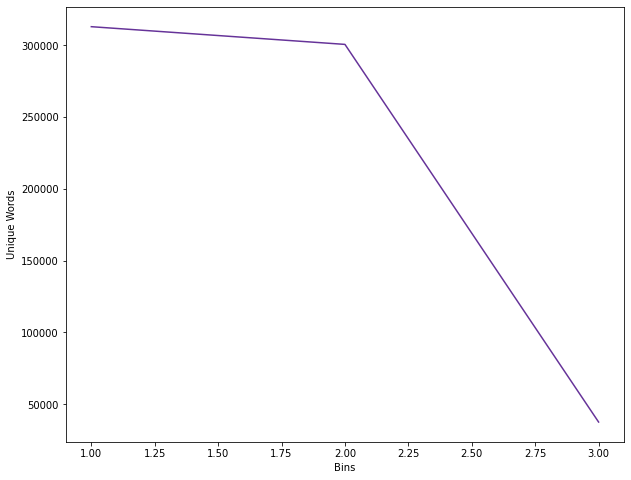

In [11]:
x = [1, 2, 3]
y = [313013, 300678,37633]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x,y, color="#663399")
ax.set_ylabel('Unique Words')
ax.set_xlabel('Bins')
plt.show()

In the process of all this cleaning, there would be several rows that have become empty.

Let's remove them and then pickle our dataset so that we don't have to do all this cleaning again.

In [12]:
def drop_empty_reviews(df):
    df = df.drop(df[~df.comment.astype(bool)].index)
    return df

if os.path.isfile(CLEANED_PICKLE) or REVIEWS_DATA_CHANGED:
  print("Reading cleaned pickle")
  reviews = pd.read_pickle(CLEANED_PICKLE, compression="gzip")
else:
  reviews = drop_empty_reviews(reviews)
  print("Pickling cleaned reviews data")
  reviews.to_pickle(CLEANED_PICKLE, compression="gzip")

REVIEWS_DATA_CHANGED = False

gc.collect()

display(reviews)

Reading cleaned pickle


,comment,rating
0,"[list, favorite]",10.0
1,[uncounted],10.0
2,"[tire, awesome]",10.0
3,"[negotiation, skill, thinking]",10.0
4,"[fantastic, hooked]",10.0
...,...,...
2638167,"[party, horrible, dumping]",3.0
2638168,"[difficult, included, build]",3.0
2638169,"[create, abstract, fun, limited, number, pictu...",3.0
2638170,"[similar, creationary]",2.5


Now that we've completed our cleaning, we need to assess what kind of model we should use to predict our ratings.

Let's see how many distinct values we have in the ratings column.

In [13]:
reviews.rating.nunique()

3213

We've got 3k+ unique values. This would definitely help us in a Regression model.

But, since we will be predicting single digit ratings, I'm going to round off the column. This will allow us to perform both regression and classification and choose what give's us a better result.

Do note that rounding off generally isn't recommended as it leads to loss of information and will affect the outcome.

I'm only doing this due to computational constraints. You should see better results in Regression models without rounding the values.

In [14]:
reviews.rating = reviews.rating.round().astype(int)

reviews

,comment,rating
0,"[list, favorite]",10
1,[uncounted],10
2,"[tire, awesome]",10
3,"[negotiation, skill, thinking]",10
4,"[fantastic, hooked]",10
...,...,...
2638167,"[party, horrible, dumping]",3
2638168,"[difficult, included, build]",3
2638169,"[create, abstract, fun, limited, number, pictu...",3
2638170,"[similar, creationary]",2


We should have 11 distinct values (0 to 10) after this. Let's see how how many ratings of each category we have.

In [15]:
reviews.rating.value_counts()

8     595145
7     520442
6     480153
9     219429
5     200143
10    140037
4     127085
3      66466
2      38184
1      18634
0         11
Name: rating, dtype: int64

We can see that we have less than 50 reviews with a zero rating. Their contribution is fairly negligible so we're going to remove them.

In [16]:
class_distrib = reviews.rating.value_counts(ascending=True)
classes_to_drop = class_distrib[class_distrib < 50].index.values

for rating in classes_to_drop:
  rows_to_drop = reviews[reviews.rating == rating].index.to_list()
  reviews.drop(rows_to_drop, inplace=True)
  print("We have {} reviews remaining".format(reviews.shape))

We have (2405718, 2) reviews remaining


Let's visualize the distribution of ratings a bit better by using a histogram

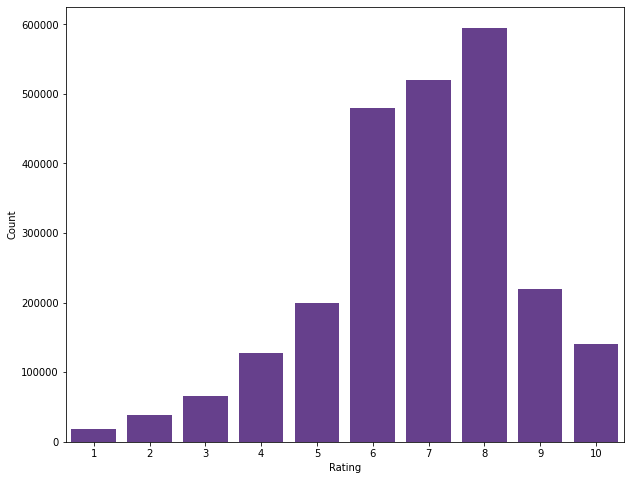

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(reviews.rating.value_counts().index, reviews.rating.value_counts(), color="#663399")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
fig.show()

Looks like the data is following somewhat of a normal distribution. Most of the reviews lie between 6 to 9. This will definitely bias the model as the dataset is imbalanced.

Now that we have a vague idea about or course of action, let's split the dataset for training and testing. We will be sampling this data mainly due to the volume and computational constraints.

In [18]:
# 10% dataset for training
train_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(reviews.comment, reviews.rating, train_size=0.1, test_size=0.1)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, train_size=0.5)

X_train = X_train.apply(' '.join)
X_dev = X_dev.apply(' '.join)
X_test = X_test.apply(' '.join)

gc.collect()

print("Number of records chosen for training: {}".format(X_train.shape[0]))
print("Number of records chosen for development: {}".format(X_dev.shape[0]))
print("Number of records chosen for testing: {}".format(X_test.shape[0]))

Number of records chosen for training: 240571
Number of records chosen for development: 120286
Number of records chosen for testing: 120286


Great! We've got that sorted. Since we have 10 unique values in ratings and we're dealing with text, let's start off with a Multinomial Naive Bayes Classifier.

But, before we do that, we need to calculate the TF-IDF values for our reviews. 

TF is the term-frequency for every word in the review i.e. the number of times a word has appeared in a review. This is fairly straightforward to calculate by using a counter per review.

IDF (Inverse Document Frequency) is slightly more trickier. Essentially, IDF is the weight of a word across all reviews. It is a measure of how common or rare a word is across the corpus. This helps us understand which words need to be prioritized over others. The closer IDF is to 0, the more common it is and the lesser it will contribute to the model. We need to target words that have a weight closer to 1 as they contribute the most.

This can be calculated by taking the total number of reviews, dividing it by the number of reviews that contain a word, and calculating the logarithm just to balance large numbers that can arise.


**********

In [0]:
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)

X_dev_vec = vectorizer.transform(X_dev)
X_test_vec = vectorizer.transform(X_test)

In [20]:
mnbc = MultinomialNB()

mnbc.fit(X_train_vec, y_train)

mnbc_predicted = mnbc.predict(X_dev_vec)

mnbc_accuracy = round(accuracy_score(mnbc_predicted, y_dev) * 100, 2)
mnbc_report = classification_report(y_dev, mnbc_predicted, digits=4, zero_division=False)

gc.collect()

print(mnbc_accuracy)

29.36


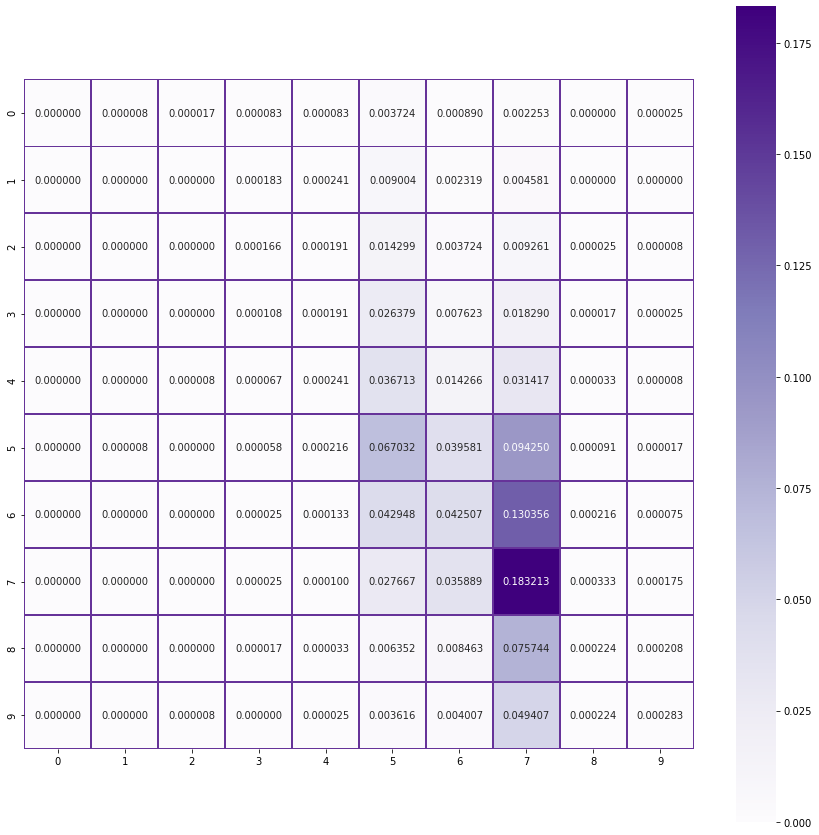

In [21]:
cm = confusion_matrix(y_dev, mnbc_predicted, normalize='all')

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, linewidths=0.5, ax=ax, cmap="Purples", linecolor="#663399", fmt="f", square=True)
fig.show()

Let's see how well our model works for a few real-world reviews

In [22]:
def check_real_review_predictions(model, vectorizer):
  review1 = "This game is absolutely pathetic. Horrible story and characters. Will never play this game again."
  review2 = "Worst."
  review3 = "One of the best games I've ever played. Amazing story and characters. Recommended."
  review4 = "good."

  test_vectorizer = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
  vectorized_review = test_vectorizer.fit_transform([review1, review2, review3, review4])
  predicted = model.predict(vectorized_review)
  return predicted

preds = check_real_review_predictions(mnbc, vectorizer)
preds

array([8, 6, 8, 7])

Well, this is exactly what we feared. All our ratings are between 6 to 8.

Looks like our model is being biased by our input data. I've got a feeling that some form of regression would work slighlty better here. Let's give Linear Regression a shot.

In [23]:
linreg = LinearRegression(n_jobs=4)

linreg.fit(X_train_vec, y_train)

linreg_predicted = linreg.predict(X_dev_vec)

linreg_accuracy_round = round(accuracy_score(np.round(linreg_predicted), y_dev) * 100, 2)

gc.collect()

print(linreg_accuracy_round)

27.33


The accuracy is a little worse but let's check with some of our reviews before we dismiss this idea.

In [24]:
preds = check_real_review_predictions(linreg, vectorizer)
preds

array([4.53441281, 1.96373693, 9.0723922 , 7.04723663])

Perfect. Looks like we are on the right track. Since this is mainly a classification problem, Logistic Regression would be a better fit here. Let's try that.

In [25]:
logreg = LogisticRegression(n_jobs=4)

logreg.fit(X_train_vec, y_train)

logreg_predicted = logreg.predict(X_dev_vec)

logreg_accuracy = round(accuracy_score(logreg_predicted, y_dev) * 100, 2)
logreg_report = classification_report(y_dev, logreg_predicted, digits=4, zero_division=False)

gc.collect()

print(logreg_accuracy)

29.9


While our acurracy is better, our solution hasn't fully converged. Let's increase the max iterations and see if our solution converges. The default value is 100 so we will be increasing it to 1000.

In [26]:
logreg = LogisticRegression(max_iter=1000, n_jobs=4)

logreg.fit(X_train_vec, y_train)

logreg_predicted = logreg.predict(X_dev_vec)

logreg_accuracy = round(accuracy_score(logreg_predicted, y_dev) * 100, 2)
logreg_report = classification_report(y_dev, logreg_predicted, digits=4, zero_division=False)

gc.collect()

print(logreg_accuracy)

30.04


While we did lose some accuracy, our solution has converged. Let's see how it classifies our reviews.

In [27]:
preds = check_real_review_predictions(logreg, vectorizer)
preds

array([ 2,  1, 10,  7])

Perfect! These ratings correspond somewhat to what we were expecting. We will pickle this model and the vocabulary of the TF-IDF vectorizer. This will be used in the Flask application that we will be building.

In [0]:
pickle.dump(vectorizer.vocabulary_, open(DATA_DIR + 'vocab.pkl', "wb"))
pickle.dump(logreg, open(DATA_DIR + 'model.pkl', "wb"))

## My contribution

Built a Flask application that predicts the rating of any review. Please visit the page [here](https://karanr.dev/rating-predictor) and enter a review. You should see the prediction for that review. This application has been deployed on Heroku and the form is available on my Portfolio website that is built using GatsbyJS. The code for this application is available on my [GitHub](https://).

You can also see a demo of this application on [YouTube](https://)

A copy of the dataset and it's pickle files are available [here](https://)